## Beyond text classification: Sequence-to-sequence learning

**Machine translation** : Convert a paragraph in a source language to its equivalent in a target language.

An encoder model turns the source sequence into an intermediate representation.

A decoder is trained to predict the next token i in the target sequence by looking at both previous tokens (0 to i - 1) and the encoded source sequence.



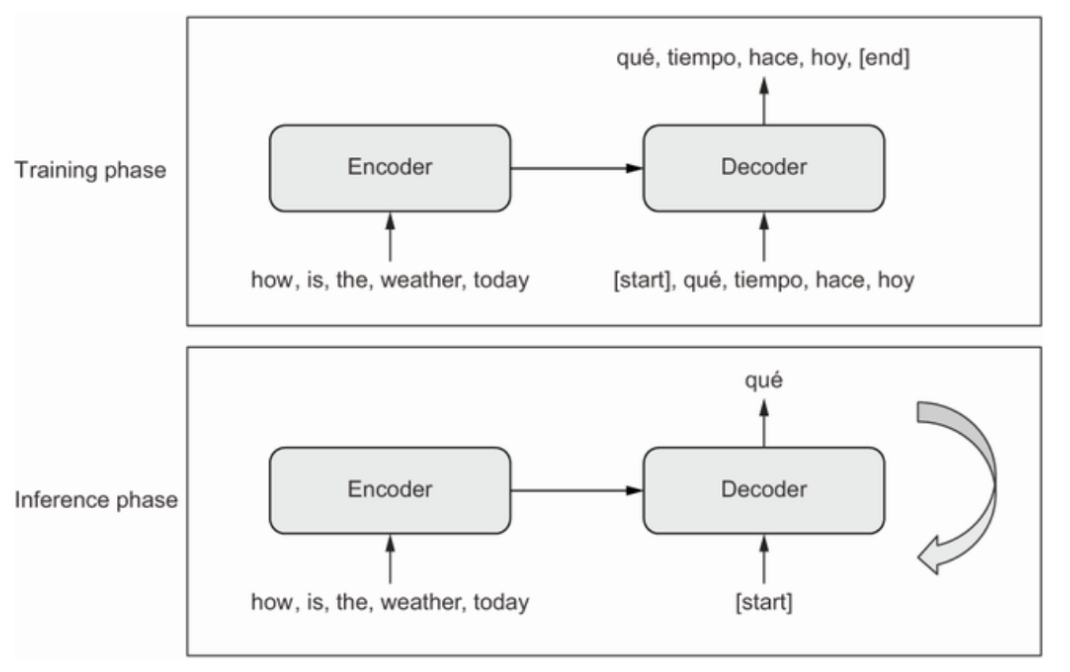

### A machine translation example

### Download data

In [1]:
!wget http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
!unzip -q spa-eng.zip

--2023-10-14 05:42:10--  http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.130.207, 74.125.68.207, 64.233.170.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.130.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2638744 (2.5M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   2.52M  2.06MB/s    in 1.2s    

2023-10-14 05:42:11 (2.06 MB/s) - ‘spa-eng.zip’ saved [2638744/2638744]



#### Add start and end token for all the output sentences. This is needed for model to know the begining and ending of a sentence. 

In [2]:
text_file = "spa-eng/spa.txt"
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    english, spanish = line.split("\t")
    spanish = "[start] " + spanish + " [end]"
    text_pairs.append((english, spanish))

#### Print a random sentence pair (English and its corresponding spanish)

In [5]:
import random
print(random.choice(text_pairs))

('I told him nothing.', '[start] No le dije nada. [end]')


This code shuffles a list of text pairs and splits it into training, validation, and test sets.

The `text_pairs` variable is a list of tuples, where each tuple contains an English sentence and its corresponding Spanish translation.

The `random.shuffle` function shuffles the list of text pairs randomly, which is a common practice to ensure that the data is not biased in any way.

The `num_val_samples` variable is set to 15% of the total number of text pairs, which determines the size of the validation set.

The `num_train_samples` variable is set to the remaining number of text pairs after subtracting twice the size of the validation set, which determines the size of the training set.

The `train_pairs` variable is a slice of the `text_pairs` list that contains the first `num_train_samples` text pairs, which are used for training the model.

The `val_pairs` variable is a slice of the `text_pairs` list that contains the next `num_val_samples` text pairs, which are used for validating the model during training.

The `test_pairs` variable is a slice of the `text_pairs` list that contains the remaining text pairs, which are used for testing the model after training.

By splitting the data into training, validation, and test sets, we can evaluate the performance of the model on unseen data and prevent overfitting.

In [6]:
import random
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

## Vectorizing the English and Spanish text pairs

This code defines a function `custom_standardization` that takes an input string and applies two text preprocessing steps to it:

1. Convert the input string to lowercase using the `tf.strings.lower` function.
2. Remove any characters in the `strip_chars` string from the input string using the `tf.strings.regex_replace` function.

The `strip_chars` string is defined outside of this function and contains a set of characters that should be removed from the input string. The `re.escape` function is used to escape any special characters in the `strip_chars` string so that they can be used in a regular expression pattern.

The `tf.strings.regex_replace` function takes three arguments: the input string, the regular expression pattern to match, and the replacement string. In this case, the regular expression pattern is set to `f"[{re.escape(strip_chars)}]"`, which matches any character in the `strip_chars` string. The replacement string is an empty string, which effectively removes any matched characters from the input string.

Overall, this function can be used as a text preprocessing step to standardize the input text by converting it to lowercase and removing any unwanted characters.

In [ ]:
import tensorflow as tf
import string
import re

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

This code sets up text vectorization layers for the source and target languages in a machine translation model. 

The `source_vectorization` layer is used to convert English text into integer sequences. It is initialized with a `max_tokens` parameter of 15000, which sets the maximum size of the vocabulary. The `output_mode` parameter is set to "int", which means that the layer will output integer sequences. The `output_sequence_length` parameter is set to 20, which means that the layer will pad or truncate sequences to a length of 20 tokens. 

The `target_vectorization` layer is used to convert Spanish text into integer sequences. It is initialized with the same `max_tokens` and `output_sequence_length` parameters as the `source_vectorization` layer, but with an additional token for the end-of-sequence marker. The `standardize` parameter is set to `custom_standardization`, which is a function that preprocesses the text by converting it to lowercase and removing unwanted characters.

The `train_english_texts` and `train_spanish_texts` variables are lists of English and Spanish sentences, respectively, extracted from the `train_pairs` dataset. These lists are used to adapt the vectorization layers to the training data using the `adapt` method.

Overall, this code sets up the text preprocessing layers for the machine translation model, which will convert the input text into integer sequences that can be fed into the model.

In [7]:


vocab_size = 15000
sequence_length = 20

source_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_english_texts = [pair[0] for pair in train_pairs]
train_spanish_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_spanish_texts)

## Preparing datasets for the translation task 

This code defines functions to format and create TensorFlow datasets for a machine translation model. 

The `format_dataset` function takes two arguments, `eng` and `spa`, which are English and Spanish sentences, respectively. It applies the `source_vectorization` and `target_vectorization` layers to the input sentences to convert them into integer sequences. It then returns a dictionary with two keys, "english" and "spanish", which map to the English and Spanish integer sequences, respectively. The "spanish" sequence is shifted by one position to the right, so that it can be used as the target sequence for the model.

The `make_dataset` function takes a list of sentence pairs as input. It extracts the English and Spanish sentences from the pairs and creates a TensorFlow dataset using the `tf.data.Dataset.from_tensor_slices` method. It then applies the `format_dataset` function to each element of the dataset using the `map` method. The dataset is batched using the `batch` method with a batch size of 64. Finally, the dataset is shuffled, prefetched, and cached using the `shuffle`, `prefetch`, and `cache` methods, respectively.

The `train_ds` and `val_ds` variables are created by calling the `make_dataset` function on the training and validation pairs, respectively. These variables represent the formatted and batched datasets that can be used to train and evaluate the machine translation model.

In [8]:
batch_size = 64

def format_dataset(eng, spa):
    eng = source_vectorization(eng)
    spa = target_vectorization(spa)
    return ({
        "english": eng,
        "spanish": spa[:, :-1],
    }, spa[:, 1:])

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

This code is used to print the shapes of the input and target data for the machine translation model. 

The `train_ds` dataset is created using the `make_dataset` function and contains batches of English and Spanish sentences that have been converted into integer sequences. The `take(1)` method is used to extract the first batch from the dataset.

The `for` loop iterates over the first batch of data and assigns the English and Spanish integer sequences to the `inputs` dictionary and the shifted Spanish integer sequences to the `targets` variable.

The `print` statements then print the shapes of the `inputs['english']`, `inputs['spanish']`, and `targets` arrays. The `inputs['english']` array has a shape of `(batch_size, sequence_length)`, where `batch_size` is the number of sentences in the batch and `sequence_length` is the length of each sentence after padding or truncation. The `inputs['spanish']` array has the same shape as `inputs['english']`. The `targets` array has a shape of `(batch_size, sequence_length)`, where `sequence_length` is one less than the length of the input sequences, since the target sequence is shifted by one position to the right.

In [9]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['english'].shape: {inputs['english'].shape}")
    print(f"inputs['spanish'].shape: {inputs['spanish'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['english'].shape: (64, 20)
inputs['spanish'].shape: (64, 20)
targets.shape: (64, 20)


# Sequence-to-sequence learning with RNNs

## GRU-based encoder

This code defines the encoder part of a sequence-to-sequence model for machine translation using Keras.

The `source` variable is an input tensor that represents the English sentence. It is defined using the `Input` function from the Keras `layers` module, with a shape of `(None,)` to allow for variable-length sequences.

The `Embedding` layer maps the input integers to dense vectors of fixed size. It is initialized with a `vocab_size` parameter that sets the size of the vocabulary, an `embed_dim` parameter that sets the dimensionality of the embedding space, and a `mask_zero` parameter that masks the zero-padding in the input sequence.

The `Bidirectional` layer applies a GRU layer to the input sequence in both forward and backward directions, and merges the outputs using the "sum" method. This allows the encoder to take into account both past and future context when generating the encoded representation of the input sequence.

The `encoded_source` variable represents the encoded representation of the input sequence, which is a fixed-size vector that summarizes the input sequence. This vector can be used as the initial hidden state of the decoder part of the sequence-to-sequence model.

Note that the `name` parameter is used to give a name to the input tensor, which can be useful for debugging and visualization purposes.

In [10]:
from tensorflow import keras
from tensorflow.keras import layers

embed_dim = 256
latent_dim = 1024

source = keras.Input(shape=(None,), dtype="int64", name="english")
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(source)
encoded_source = layers.Bidirectional(layers.GRU(latent_dim), merge_mode="sum")(x)

## GRU-based decoder and the end-to-end model

This code defines the decoder part of a sequence-to-sequence model for machine translation using Keras.

The `past_target` variable is an input tensor that represents the target sequence up to the current time step. It is defined using the `Input` function from the Keras `layers` module, with a shape of `(None,)` to allow for variable-length sequences.

The `Embedding` layer maps the input integers to dense vectors of fixed size. It is initialized with a `vocab_size` parameter that sets the size of the vocabulary, an `embed_dim` parameter that sets the dimensionality of the embedding space, and a `mask_zero` parameter that masks the zero-padding in the input sequence.

The `GRU` layer is a type of recurrent neural network layer that applies a gated recurrent unit to the input sequence. It is initialized with a `latent_dim` parameter that sets the dimensionality of the output space, and a `return_sequences` parameter that specifies whether to return the full sequence of outputs or only the last output.

The `initial_state` parameter of the `decoder_gru` layer is set to `encoded_source`, which is the output of the encoder part of the model. This initializes the hidden state of the decoder GRU with the final hidden state of the encoder GRU, which allows the decoder to take into account the entire input sequence when generating the output sequence.

The `Dropout` layer randomly sets a fraction of the input units to 0 at each update during training time, which helps prevent overfitting.

The `Dense` layer applies a softmax activation function to the output of the previous layer, which produces a probability distribution over the vocabulary for each position in the target sequence.

Finally, the `seq2seq_rnn` model is defined using the `Model` function from the Keras `models` module, with `source` and `past_target` as inputs and `target_next_step` as output. This model can be used to train and evaluate the sequence-to-sequence model for machine translation.

In [11]:
past_target = keras.Input(shape=(None,), dtype="int64", name="spanish")
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(past_target)
decoder_gru = layers.GRU(latent_dim, return_sequences=True)
x = decoder_gru(x, initial_state=encoded_source)
x = layers.Dropout(0.5)(x)
target_next_step = layers.Dense(vocab_size, activation="softmax")(x)
seq2seq_rnn = keras.Model([source, past_target], target_next_step)

## Training our recurrent sequence-to-sequence model

This code compiles and trains the sequence-to-sequence model for machine translation using Keras.

The `compile` method configures the model for training by specifying the optimizer, loss function, and evaluation metrics. In this case, the optimizer is set to "rmsprop", which is a popular optimization algorithm for deep learning. The loss function is set to "sparse_categorical_crossentropy", which is a common choice for multi-class classification problems with integer labels. The evaluation metric is set to "accuracy", which measures the proportion of correctly classified examples.

The `fit` method trains the model on the training dataset (`train_ds`) for a specified number of epochs (15 in this case), and validates the model on the validation dataset (`val_ds`) after each epoch. During training, the model updates its parameters to minimize the loss function using backpropagation and the optimizer. The validation dataset is used to monitor the performance of the model on unseen data and prevent overfitting.

In [12]:
seq2seq_rnn.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
seq2seq_rnn.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
1302/1302 [==============================] - 150s 101ms/step - loss: 4.6762 - accuracy: 0.3188 - val_loss: 3.9273 - val_accuracy: 0.3865
Epoch 2/15
1302/1302 [==============================] - 111s 85ms/step - loss: 3.7148 - accuracy: 0.4162 - val_loss: 3.2840 - val_accuracy: 0.4660
Epoch 3/15
1302/1302 [==============================] - 110s 85ms/step - loss: 3.2060 - accuracy: 0.4733 - val_loss: 2.8816 - val_accuracy: 0.5171
Epoch 4/15
1302/1302 [==============================] - 110s 85ms/step - loss: 2.8603 - accuracy: 0.5136 - val_loss: 2.6377 - val_accuracy: 0.5507
Epoch 5/15
1302/1302 [==============================] - 120s 93ms/step - loss: 2.5877 - accuracy: 0.5464 - val_loss: 2.4625 - val_accuracy: 0.5746
Epoch 6/15
1302/1302 [==============================] - 111s 86ms/step - loss: 2.3629 - accuracy: 0.5760 - val_loss: 2.3263 - val_accuracy: 0.5956
Epoch 7/15
1302/1302 [==============================] - 111s 86ms/step - loss: 2.1787 - accuracy: 0.5990 - val_loss: 

# Translating new sentences with our RNN encoder and decoder

This code defines a function `decode_sequence` that uses the trained sequence-to-sequence model to translate an input sentence from English to Spanish.

The `spa_vocab` variable is a list of words in the Spanish vocabulary, obtained from the target vectorization layer.

The `spa_index_lookup` variable is a dictionary that maps integer indices to words in the Spanish vocabulary.

The `max_decoded_sentence_length` variable sets the maximum length of the output sentence.

The `decode_sequence` function takes an input sentence in English as a string, tokenizes it using the source vectorization layer, and initializes the decoded sentence as the string "[start]".

The function then enters a loop that iteratively predicts the next word in the output sentence using the trained sequence-to-sequence model. At each iteration, the function tokenizes the current decoded sentence using the target vectorization layer, and passes both the tokenized input sentence and the tokenized decoded sentence to the model's `predict` method. The `predict` method returns a tensor of shape `(batch_size, sequence_length, vocab_size)` that contains the predicted probabilities for each word in the Spanish vocabulary at each position in the output sequence.

The function then selects the word with the highest predicted probability at the current position, using the `argmax` method of the NumPy library. The selected word is then appended to the decoded sentence, and the loop continues until either the maximum length is reached or the special token "[end]" is predicted.

Finally, the function returns the decoded sentence as a string.

The code then defines a list `test_eng_texts` that contains the English sentences from the test set, and uses the `decode_sequence` function to translate 20 randomly selected sentences from the test set. The input sentence and the corresponding translated sentence are printed for each example.

In [13]:
import numpy as np
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])
        next_token_predictions = seq2seq_rnn.predict(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
I'm a councillor, too.
1/1 [==============================] - 0s 37ms/step
[start] soy un [UNK] [end]
-
We're going to Boston.
1/1 [==============================] - 0s 33ms/step
[start] vamos a boston [end]
-
The boy has an apple in his pocket.
1/1 [==============================] - 0s 22ms/step
[start] el niño tiene una manzana en su bolsillo [end]
-
Tom has been crying all night.
1/1 [==============================] - 0s 24ms/step
[start] tom ha estado viendo la noche [end]
-
Tom told me that he didn't want to come home empty-handed.
1/1 [==============================] - 0s 25ms/step
[start] tom me dijo que no quería venir a casa [end]
-
Republicans were furious.
1/1 [==============================] - 0s 22ms/step
[start] [UNK] [UNK] [end]
-
May I borrow your dictionary?
1/1 [==============================] - 0s 24ms/step
[start] me puedes prestar tu diccionario [end]
-
I visited my grandmother's house.
1/1 [==============================] - 0s 23ms/step
[start] visité la casa de

## Summary